# EEGNet for CNP classification 

## Load Raw data

In [ ]:
from pathlib import Path

root_dir = Path("/Volumes/Public/data_keri")

# find motor imagery and resting state files and exclude unused files
set_files_all = list(root_dir.rglob("*.set"))
set_files_all = [f for f in set_files_all if "Unused AB" not in f.parts]
set_files_RS = list(root_dir.rglob("*_EC.set")) + list(root_dir.rglob("*_EO.set")) + list(root_dir.rglob("*_baseline.set"))
set_files_RS = [f for f in set_files_RS if "Unused AB" not in f.parts]
set_files_MI = [f for f in set_files_all if f not in set_files_RS and f.suffix == ".set"]

print(f"Find {len(set_files_all)} Files in Total")
print(f"Find {len(set_files_RS)} Resting State Files")
print(f"Find {len(set_files_MI)} Motor Imagery Files")

Find 360 Files in Total
Find 149 Resting State Files
Find 211 Motor Imagery Files


In [97]:
import numpy as np
import mne
from tqdm import tqdm # show progress bar
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA # 使用 scikit-learn 的 PCA

mne.set_log_level('ERROR')  # 或 warning

labelled_patients = {'PwP' : 0, 'PnP' : 1, 'PdP' : 2, 'AB' : 3}



def load_all_raws(file_list, set_label):
    """
    Load all raw data from a list of files and assign labels based on the provided set_label.
    Args:
        file_list (list): List of file paths to load raw data from.
        set_label (dict): Dictionary mapping labels to their corresponding values.
    Returns:
        raws (list): List of loaded raw data.
        labels (list): List of labels corresponding to the loaded raw data.
    """
    raws = []
    labels = []
    for f in tqdm(file_list, desc="Loading all raw files"):
        try:
            raw = mne.io.read_raw_eeglab(str(f), preload=True)
            
            label = [key for key in set_label.keys() if key in f.parts]
            if label:
                label_value = set_label[label[0]]
                raws.append(raw)
                labels.append(label_value)
            else:
                print(f"No label found for file: {f}")
        except Exception as e:
            print(f"Error processing {f}: {e}")
    
    return raws, labels

def eeg_raw_preprocess(raw_data):
    """
    Preprocess raw EEG data by applying filtering and cropping.
    Args:
        raw_data (mne.io.Raw): Raw EEG data to preprocess.
    Returns:
        raw_data (mne.io.Raw): Preprocessed raw EEG data.
    """
    raw_data = raw_data.copy().crop(tmin=0, tmax=raw_data.times[-1])   # remove baseline
    raw_data.filter(l_freq=0.1, h_freq=None, fir_design='firwin', skip_by_annotation='edge') # high pass filter 0.1 HZ
    raw_data.notch_filter(freqs=50, fir_design='firwin', skip_by_annotation='edge') # remove 50Hz noise
    raw_data.filter(l_freq=None, h_freq=100, fir_design='firwin', skip_by_annotation='edge')  # low pass filter 100 Hz
    raw_data.set_eeg_reference(projection=True)  # 设置参考电极
    # ICA


    return raw_data

def eeg_augment(raw_data, n_aug=2, noise_std=0.01, scale_range=(0.9, 1.1), shift_range=(10, 50), random_seed=42):
    """
    Augment raw EEG data by adding noise, scaling, and optional time shift.
    """
    rng = np.random.default_rng(random_seed)
    augmented_data = []
    
    data_orig = raw_data.get_data()
    ch_std = np.std(data_orig, axis=1, keepdims=True)
    
    for _ in range(n_aug):
        # Copy original data
        data = data_orig.copy()
        
        # Add Gaussian noise (scaled per channel)
        noise = rng.normal(0, noise_std, size=data.shape) * ch_std
        data += noise
        
        # Random scaling
        scale = rng.uniform(*scale_range)
        data *= scale
        
        # Time shift
        shift = rng.integers(shift_range[0], shift_range[1])
        data = np.roll(data, shift=shift, axis=1)
        
        # Create new Raw object
        new_raw = mne.io.RawArray(data, raw_data.info)
        
        # Optionally set montage
        montage = raw_data.get_montage()
        if montage is not None:
            new_raw.set_montage(montage)
        
        augmented_data.append(new_raw)
    
    return augmented_data

def split_into_epochs_with_metadata(raw_data, label_value, duration=.0, overlap=0.0):
    events = mne.make_fixed_length_events(raw_data, id=1, duration=duration, overlap=overlap * duration) # create fixed-length events
    n_epochs = len(events) # number of epochs
    metadata = pd.DataFrame({"label": [label_value] * n_epochs}) # create metadata with label
    epochs = mne.Epochs(raw_data, events=events, event_id=dict(segment=1), tmin=0, tmax=duration, baseline=None, metadata=metadata, preload=True)

    return epochs

def run_raw_pipeline(raws_group, labels_group, duration=1.0, overlap=0.0, augment=False):
    """
    Run the preprocessing pipeline on a group of raw EEG data and split them into epochs.
    Args:
        raws_group (list): List of raw EEG data to preprocess.
        labels_group (list): List of labels corresponding to the raw EEG data.
        duration (float): Duration of each epoch in seconds.
        overlap (float): Overlap between epochs in seconds.
    Returns:
        epochs_all (mne.Epochs): Concatenated epochs from all raw data. 
    """
    epochs_list = []
    for raw, label_value in zip(raws_group, labels_group):
        preprocessed_raw = eeg_raw_preprocess(raw)
        if augment:
            augmented_raws = eeg_augment(preprocessed_raw, n_aug=3, noise_std=0.005, scale_range=(0.95, 1.05), shift_range=(20, 100), random_seed=42)
            for aug_raw in augmented_raws:
                epochs = split_into_epochs_with_metadata(aug_raw, label_value=label_value, duration=duration, overlap=overlap)
                epochs_list.append(epochs)
        epochs = split_into_epochs_with_metadata(
            preprocessed_raw,
            label_value=label_value,
            duration=duration,
            overlap=overlap
        )
        epochs_list.append(epochs)
    epochs_all = mne.concatenate_epochs(epochs_list)
    
    return epochs_all

##############################
#########  workflow  #########
##############################

raws, labels = load_all_raws(set_files_RS, labelled_patients) # load raw data and labels
raw_indices = np.arange(len(raws)) # create indices for raw data 
print(f"Total {str(raw_indices.shape[0])} raw files loaded.")

# 分割训练集 (70%) 和临时集 (30%)
train_indices, temp_indices = train_test_split(
    raw_indices,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

# 从标签列表中提取临时集的标签用于再次分层
temp_labels = [labels[i] for i in temp_indices]

# 分割验证集 (15%) 和测试集 (15%)
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5, # 30% * 0.5 = 15%
    stratify=temp_labels,
    random_state=42
)

# 根据索引创建各数据集的 raws 和 labels 列表
raws_train = [raws[i] for i in train_indices]
labels_train = [labels[i] for i in train_indices]

raws_val = [raws[i] for i in val_indices]
labels_val = [labels[i] for i in val_indices]

raws_test = [raws[i] for i in test_indices]
labels_test = [labels[i] for i in test_indices]



epochs_train = run_raw_pipeline(raws_train, labels_train, duration=2.0, overlap=0.0)
epochs_val   = run_raw_pipeline(raws_val, labels_val, duration=2.0, overlap=0.0)
epochs_test  = run_raw_pipeline(raws_test, labels_test, duration=2.0, overlap=0.0)





Loading all raw files: 100%|██████████| 149/149 [00:05<00:00, 29.52it/s]


Total 149 raw files loaded.


In [98]:
from sklearn.decomposition import PCA

def apply_cpa_with_sklearn(epochs_train, epochs_val, epochs_test, n_components):
    """
    使用 scikit-learn 的 PCA 实现类别PCA (CPA) 降维。

    参数:
    ----------
    epochs_train, epochs_val, epochs_test : mne.Epochs
        训练、验证和测试的 Epochs 对象。
    n_components : int
        降维后保留的主成分数量。

    返回:
    -------
    tuple
        包含三个新创建的 mne.EpochsArray 对象的元组，分别是降维后的:
        (epochs_train_cpa, epochs_val_cpa, epochs_test_cpa)
    """
    # 1. 在训练集上为每个类别拟合一个 sklearn.PCA 模型
    print("Fitting sklearn PCA models on the training set...")
    cpa_models = {}
    unique_labels = sorted(epochs_train.metadata['label'].unique())
    
    for label in unique_labels:
        epochs_class = epochs_train[epochs_train.metadata['label'] == label]
        
        # 从 MNE 对象中获取 3D 数据
        data_class = epochs_class.get_data() # Shape: (n_epochs, n_channels, n_times)
        n_epochs, n_channels, n_times = data_class.shape
        
        # 为 sklearn 重塑数据: (n_epochs, n_channels, n_times) -> (n_epochs * n_times, n_channels)
        data_reshaped = data_class.transpose(0, 2, 1).reshape(-1, n_channels)
        
        # 初始化并拟合 PCA
        pca = PCA(n_components=n_components, random_state=42)
        pca.fit(data_reshaped)
        
        cpa_models[label] = pca
        print(f"  - Fitted PCA for label '{label}' with {n_channels} -> {n_components} components.")

    # 2. 定义一个辅助函数来应用模型并重建 Epochs 对象
    def transform_epochs(epochs, models):
        if epochs is None or len(epochs) == 0:
            return None
            
        original_info = epochs.info
        original_tmin = epochs.tmin
        
        transformed_data_list = []
        metadata_list = []

        # 按类别应用对应的模型
        for label, model in models.items():
            epochs_subset = epochs[epochs.metadata['label'] == label]
            
            if len(epochs_subset) > 0:
                # 获取并重塑数据
                data_subset = epochs_subset.get_data()
                n_sub_epochs, n_sub_channels, n_sub_times = data_subset.shape
                reshaped_subset = data_subset.transpose(0, 2, 1).reshape(-1, n_sub_channels)
                
                # 应用变换
                transformed_reshaped = model.transform(reshaped_subset) # Shape: (n_sub_epochs * n_sub_times, n_components)
                
                # 逆向重塑回 MNE 格式
                # -> (n_sub_epochs, n_sub_times, n_components)
                transformed_3d = transformed_reshaped.reshape(n_sub_epochs, n_sub_times, n_components)
                # -> (n_sub_epochs, n_components, n_sub_times)
                final_data = transformed_3d.transpose(0, 2, 1)
                
                transformed_data_list.append(final_data)
                metadata_list.append(epochs_subset.metadata)

        # 合并所有处理过的数据和元数据
        if not transformed_data_list:
            return None
        all_transformed_data = np.concatenate(transformed_data_list, axis=0)
        all_metadata = pd.concat(metadata_list, ignore_index=True)

        # 因为通道已变，需要创建新的 MNE Info 对象
        new_ch_names = [f'CPA_{i+1}' for i in range(n_components)]
        new_info = mne.create_info(ch_names=new_ch_names, sfreq=original_info['sfreq'], ch_types='eeg')
        
        # 创建新的 EpochsArray 对象
        new_epochs = mne.EpochsArray(all_transformed_data, info=new_info, tmin=original_tmin, metadata=all_metadata)
        
        # （可选）恢复原始顺序，但这对于CNN训练通常不是必需的
        # original_order = np.concatenate([epochs[epochs.metadata['label'] == l].selection for l in models.keys() if len(epochs[epochs.metadata['label'] == l]) > 0])
        # sort_indices = np.argsort(np.argsort(original_order))
        # return new_epochs[sort_indices]
        return new_epochs

    # 3. 将模型应用到所有数据集
    print("\nApplying sklearn PCA models to train, validation, and test sets...")
    epochs_train_cpa = transform_epochs(epochs_train, cpa_models)
    print("  - Applied to training set.")
    
    epochs_val_cpa = transform_epochs(epochs_val, cpa_models)
    print("  - Applied to validation set.")

    epochs_test_cpa = transform_epochs(epochs_test, cpa_models)
    print("  - Applied to test set.")

    print(f"\nCPA complete. Data dimension reduced to {n_components} channels.")
    
    return epochs_train_cpa, epochs_val_cpa, epochs_test_cpa



# 设定你想要降至的维度
N_COMPONENTS = 15 

epochs_train_cpa, epochs_val_cpa, epochs_test_cpa = apply_cpa_with_sklearn(
    epochs_train, 
    epochs_val, 
    epochs_test, 
    n_components=N_COMPONENTS
)

# 检查降维后的数据维度
print("\n--- Dimensions after sklearn CPA ---")
if epochs_train_cpa:
    print("Train data shape:", epochs_train_cpa.get_data().shape)
    # 你可以看到通道名已经改变
    print("New channel names:", epochs_train_cpa.ch_names)
if epochs_val_cpa:
    print("Validation data shape:", epochs_val_cpa.get_data().shape)
if epochs_test_cpa:
    print("Test data shape:", epochs_test_cpa.get_data().shape)


Fitting sklearn PCA models on the training set...
  - Fitted PCA for label '0' with 64 -> 15 components.
  - Fitted PCA for label '1' with 64 -> 15 components.
  - Fitted PCA for label '2' with 64 -> 15 components.
  - Fitted PCA for label '3' with 64 -> 15 components.

Applying sklearn PCA models to train, validation, and test sets...
  - Applied to training set.
  - Applied to validation set.
  - Applied to test set.

CPA complete. Data dimension reduced to 15 channels.

--- Dimensions after sklearn CPA ---
Train data shape: (6253, 15, 513)
New channel names: ['CPA_1', 'CPA_2', 'CPA_3', 'CPA_4', 'CPA_5', 'CPA_6', 'CPA_7', 'CPA_8', 'CPA_9', 'CPA_10', 'CPA_11', 'CPA_12', 'CPA_13', 'CPA_14', 'CPA_15']
Validation data shape: (1296, 15, 513)
Test data shape: (1404, 15, 513)


In [99]:
interest_bands = {
    "delta": (1, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30)
}

band_data_list = []
band_names = []

def extract_band_layers(epochs_all, interest_bands):
    band_data_list = []
    
    for band_name, (low_f, high_f) in interest_bands.items():
        print(f"Filtering band: {band_name} ({low_f}-{high_f} Hz)")
        
        epochs_band = epochs_all.copy().filter(
            l_freq=low_f,
            h_freq=high_f,
            fir_design='firwin'
        )
        
        X_band = epochs_band.get_data()  # (n_epochs, n_channels, n_times)
        band_data_list.append(X_band)
    
    X_stacked = np.stack(band_data_list, axis=1)  # (n_epochs, n_bands, n_channels, n_times)
    y = epochs_all.metadata["label"].values
    
    return X_stacked, y

# train
X_train, y_train = extract_band_layers(epochs_train_cpa, interest_bands)

# val
X_val, y_val = extract_band_layers(epochs_val_cpa, interest_bands)

# test
X_test, y_test = extract_band_layers(epochs_test_cpa, interest_bands)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


Filtering band: delta (1-4 Hz)
Filtering band: theta (4-8 Hz)
Filtering band: alpha (8-13 Hz)
Filtering band: beta (13-30 Hz)
Filtering band: delta (1-4 Hz)
Filtering band: theta (4-8 Hz)
Filtering band: alpha (8-13 Hz)
Filtering band: beta (13-30 Hz)
Filtering band: delta (1-4 Hz)
Filtering band: theta (4-8 Hz)
Filtering band: alpha (8-13 Hz)
Filtering band: beta (13-30 Hz)
(6253, 4, 15, 513) (6253,)
(1296, 4, 15, 513) (1296,)
(1404, 4, 15, 513) (1404,)


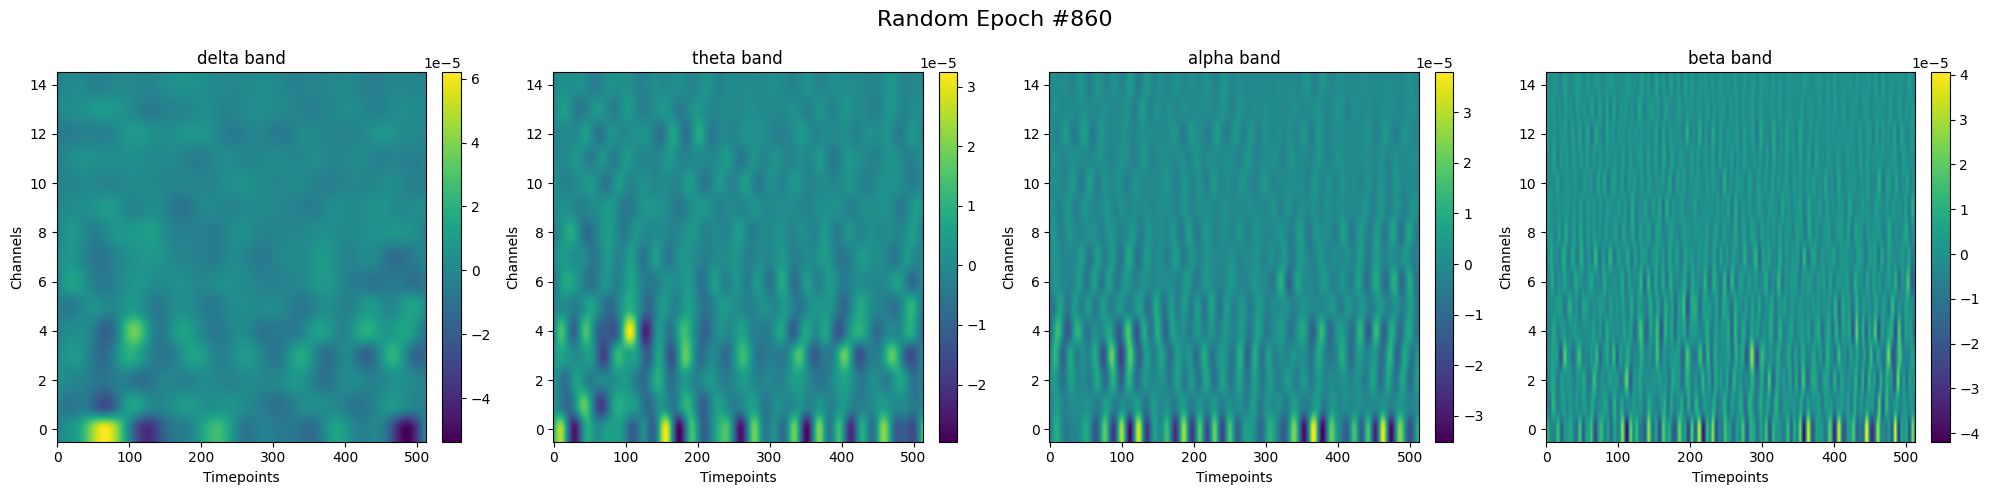

In [100]:
import matplotlib.pyplot as plt

# 保存训练集
np.savez_compressed("eeg_train.npz", X=X_train, y=y_train)

# 保存验证集
np.savez_compressed("eeg_val.npz", X=X_val, y=y_val)

# 保存测试集
np.savez_compressed("eeg_test.npz", X=X_test, y=y_test)


# 假设 X_train 存在
# X_train.shape = (n_epochs, n_bands, n_channels, n_times)

# 随机取一个 epoch
random_idx = np.random.randint(0, X_train.shape[0])
band_names = ["delta", "theta", "alpha", "beta"]

# 提取每个 band
band_data_list = []

for band_idx in range(X_train.shape[1]):
    data_band = X_train[random_idx, band_idx, :, :]  # (channels, timepoints)
    band_data_list.append(data_band)

# Plot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, ax in enumerate(axes):
    im = ax.imshow(
        band_data_list[i],
        aspect='auto',
        origin='lower',
        cmap='viridis'
    )
    ax.set_title(f"{band_names[i]} band")
    ax.set_xlabel("Timepoints")
    ax.set_ylabel("Channels")

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f"Random Epoch #{random_idx}", fontsize=16)
plt.tight_layout()
plt.show()

## Load Pre-processed Data

In [101]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import gc

# ---------- STEP 1. 加载各个数据分割 ----------
# 假设 .npz 文件中的 'X' 已经是 (样本数, 频率分层, 通道, 时间点) 的形状
# 例如 (N, 4, 64, 256)

print("--> 加载数据...")
train_data = np.load("eeg_train.npz")
X_train = train_data["X"]
y_train = train_data["y"]

val_data = np.load("eeg_val.npz")
X_val = val_data["X"]
y_val = val_data["y"]

test_data = np.load("eeg_test.npz")
X_test = test_data["X"]
y_test = test_data["y"]

# 验证数据形状是否符合预期
# 预期: (样本数, 频率分层, 通道数, 时间点)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("-" * 30)


# ---------- STEP 2. 检查一个样本 ----------

# 随机选择一个训练样本
i = np.random.randint(0, len(X_train))
sample = X_train[i]       # 形状: (4, 64, 256)
label = y_train[i]

# 转换为 PyTorch 张量
sample_tensor = torch.from_numpy(sample).float()

print("单个样本张量的形状:", sample_tensor.shape)

# ==================== MODIFICATION START ====================
# 释放用于检查的临时变量
del i, sample, label, sample_tensor
gc.collect()
# ===================== MODIFICATION END =====================
print("-" * 30)


# ---------- STEP 3. 转换为 PyTorch 张量并释放内存 ----------
print("--> 转换数据为张量并释放内存...")
# 直接从 numpy 转换
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()

X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).long()

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

# 删除已不再需要的 NumPy 变量以释放大量内存
del train_data, X_train, y_train
del val_data, X_val, y_val
del test_data, X_test, y_test
# 强制 Python 进行垃圾回收
gc.collect()

print("X_train_tensor 形状:", X_train_tensor.shape) # 应为 (N, 4, 64, 256)
print("NumPy 内存已优化。")
print("-" * 30)


# ---------- STEP 4. 从训练集计算均值/标准差 ----------
# 对一个 (N, Freq, Chan, Time) 张量计算统计数据
# 我们希望得到每个通道 (Chan) 的均值和标准差，因此在其他维度上进行计算
# N=dim0, Freq=dim1, Chan=dim2, Time=dim3
# 我们在 dim 0, 1, 3 上计算，保留 dim 2
mean = X_train_tensor.mean(dim=(0, 1, 3))      # 形状: (64,)
std = X_train_tensor.std(dim=(0, 1, 3)) + 1e-6  # 形状: (64,)

print("Mean 形状:", mean.shape)
print("Std 形状:", std.shape)
print("-" * 30)


# ---------- STEP 5. 原地标准化所有数据分割 ----------
def standardize_inplace(X_tensor, mean, std):
    """
    对一个 (N, Freq, Chan, Time) 的张量进行原地标准化 (in-place)。
    这可以避免创建数据的副本，从而节省内存。
    mean 和 std 的形状为 (Chan,)。
    """
    # 为了利用广播机制，我们需要将 mean 和 std 的形状从 (64,) 调整为 (1, 1, 64, 1)
    mean_reshaped = mean.view(1, 1, -1, 1)
    std_reshaped = std.view(1, 1, -1, 1)
    
    # 应用原地标准化: X_tensor = (X_tensor - mean) / std
    X_tensor.sub_(mean_reshaped).div_(std_reshaped)

print("--> 原地标准化数据...")
# 直接在原始张量上进行修改，不创建新的变量
standardize_inplace(X_train_tensor, mean, std)
standardize_inplace(X_val_tensor, mean, std)
standardize_inplace(X_test_tensor, mean, std)
print("标准化完成。")
print("-" * 30)


# ---------- STEP 6. 构建 TensorDataset 并再次释放内存 ----------
print("--> 构建 TensorDataset...")
train_set = TensorDataset(X_train_tensor, y_train_tensor)
val_set = TensorDataset(X_val_tensor, y_val_tensor)
test_set = TensorDataset(X_test_tensor, y_test_tensor)
print("TensorDataset 构建完成。")

# TensorDataset 创建后，原始的大张量就不再需要了，可以安全删除
print("--> 释放 PyTorch 张量以优化内存...")
del X_train_tensor, y_train_tensor
del X_val_tensor, y_val_tensor
del X_test_tensor, y_test_tensor
# 再次强制垃圾回收
gc.collect()
print("张量内存已优化。")
print("-" * 30)


# ---------- STEP 7. 创建 DataLoader ----------

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


# ---------- STEP 8. 测试 DataLoader ----------

print("--> 测试 DataLoader...")
for xb, yb in train_loader:
    print("Batch shape:", xb.shape)     # → 应为 (64, 4, 64, 256)
    print("Labels shape:", yb.shape)    # → 应为 (64,)
    break
print("-" * 30)


--> 加载数据...
Train shape: (6253, 4, 15, 513) (6253,)
Val shape: (1296, 4, 15, 513) (1296,)
Test shape: (1404, 4, 15, 513) (1404,)
------------------------------
单个样本张量的形状: torch.Size([4, 15, 513])
------------------------------
--> 转换数据为张量并释放内存...
X_train_tensor 形状: torch.Size([6253, 4, 15, 513])
NumPy 内存已优化。
------------------------------
Mean 形状: torch.Size([15])
Std 形状: torch.Size([15])
------------------------------
--> 原地标准化数据...
标准化完成。
------------------------------
--> 构建 TensorDataset...
TensorDataset 构建完成。
--> 释放 PyTorch 张量以优化内存...
张量内存已优化。
------------------------------
--> 测试 DataLoader...
Batch shape: torch.Size([64, 4, 15, 513])
Labels shape: torch.Size([64])
------------------------------


## Model Define

In [102]:
import torch
import torch.nn as nn
import numpy as np

# 为可复现性设置随机种子
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

class SeparableConv2d(nn.Module):
    """PyTorch implementation of Keras's SeparableConv2D."""
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size,
                                   groups=in_channels, bias=bias, padding=padding)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block."""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class EEGNet(nn.Module):
    """EEGNet model adapted for multi-band frequency input."""
    def __init__(self, nb_classes, FreqBands=4, Chans=64, Samples=256,
                 dropoutRate=0.5, kernLength=256, F1=96,
                 D=1, F2=96, dropoutType='Dropout'):
        super(EEGNet, self).__init__()
        if dropoutType == 'SpatialDropout2D':
            self.dropout_layer = nn.Dropout2d
        elif dropoutType == 'Dropout':
            self.dropout_layer = nn.Dropout
        else:
            raise ValueError("dropoutType must be 'SpatialDropout2D' or 'Dropout'")

        self.block1 = nn.Sequential(
            nn.Conv2d(FreqBands, F1, (1, kernLength), padding=(0, kernLength // 2), bias=False),
            nn.BatchNorm2d(F1),
            nn.Conv2d(F1, F1 * D, (Chans, 1), groups=F1, bias=False), 
            nn.BatchNorm2d(F1 * D),
            nn.GELU(),
            nn.AvgPool2d((1, 4)),
            self.dropout_layer(dropoutRate)
        )
        self.depthwise_conv = self.block1[2]
        self.block2 = nn.Sequential(
            SeparableConv2d(F1 * D, F2, (1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(F2),
            nn.GELU(),
            nn.AvgPool2d((1, 8)),
            self.dropout_layer(dropoutRate)
        )
        self.attention = SEBlock(F2)
        with torch.no_grad():
            dummy_input = torch.zeros(1, FreqBands, Chans, Samples)
            output_size = self._forward_features(dummy_input).shape[1]
        self.classifier = nn.Linear(output_size, nb_classes)

    def _forward_features(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.attention(x)
        return torch.flatten(x, 1)

    def forward(self, x):
        return self.classifier(self._forward_features(x))

    def apply_constraints(self):
        self.depthwise_conv.weight.data = torch.renorm(
            self.depthwise_conv.weight.data, p=2, dim=0, maxnorm=1.0
        )

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Performs one full training pass."""
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        if hasattr(model, 'apply_constraints'):
            model.apply_constraints()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    """Performs evaluation on a dataset."""
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return val_loss / total, correct / total

## Model Config

In [103]:
xb, yb = next(iter(train_loader))
_, FreqBands, Chans, Samples = xb.shape

model = EEGNet(
    nb_classes=len(np.unique(yb)),
    FreqBands=FreqBands,
    Chans=Chans,
    Samples=Samples,
    dropoutRate=0.3,
    kernLength=64,
    F1=8,
    D=2,
    F2=16,
    dropoutType='Dropout'
)


if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model.to(device)

print(f"Using device: {device}")

for xb, yb in train_loader:
    xb, yb = xb.to(device), yb.to(device)
    print(xb.shape)
    break

Using device: mps
torch.Size([64, 4, 15, 513])


## Main Loop

In [104]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}
num_epochs = 30
best_val_acc = 0.0

print("\n--> 开始训练...")
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)

    print(f"Epoch {epoch:02d}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
        print(f"    模型已保存，最优验证准确率: {best_val_acc:.4f}")

print("训练完成。")

print("\n--> 加载最优模型进行测试...")
model.load_state_dict(torch.load("best_model.pt"))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\n最终测试结果: Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")


--> 开始训练...
Epoch 01: Train Loss=1.3027, Acc=0.3789 | Val Loss=1.1341, Acc=0.5100
    模型已保存，最优验证准确率: 0.5100
Epoch 02: Train Loss=0.8217, Acc=0.6997 | Val Loss=0.4878, Acc=0.8009
    模型已保存，最优验证准确率: 0.8009
Epoch 03: Train Loss=0.2735, Acc=0.9295 | Val Loss=0.2608, Acc=0.9066
    模型已保存，最优验证准确率: 0.9066
Epoch 04: Train Loss=0.1044, Acc=0.9757 | Val Loss=0.1175, Acc=0.9591
    模型已保存，最优验证准确率: 0.9591
Epoch 05: Train Loss=0.0603, Acc=0.9885 | Val Loss=0.0574, Acc=0.9823
    模型已保存，最优验证准确率: 0.9823
Epoch 06: Train Loss=0.0451, Acc=0.9904 | Val Loss=0.0548, Acc=0.9815
Epoch 07: Train Loss=0.0361, Acc=0.9912 | Val Loss=0.0373, Acc=0.9900
    模型已保存，最优验证准确率: 0.9900
Epoch 08: Train Loss=0.0249, Acc=0.9949 | Val Loss=0.0463, Acc=0.9869
Epoch 09: Train Loss=0.0231, Acc=0.9941 | Val Loss=0.0260, Acc=0.9938
    模型已保存，最优验证准确率: 0.9938
Epoch 10: Train Loss=0.0207, Acc=0.9949 | Val Loss=0.0495, Acc=0.9853
Epoch 11: Train Loss=0.0136, Acc=0.9974 | Val Loss=0.0387, Acc=0.9900
Epoch 12: Train Loss=0.0168, Acc=0.

Generating and saving loss plot...


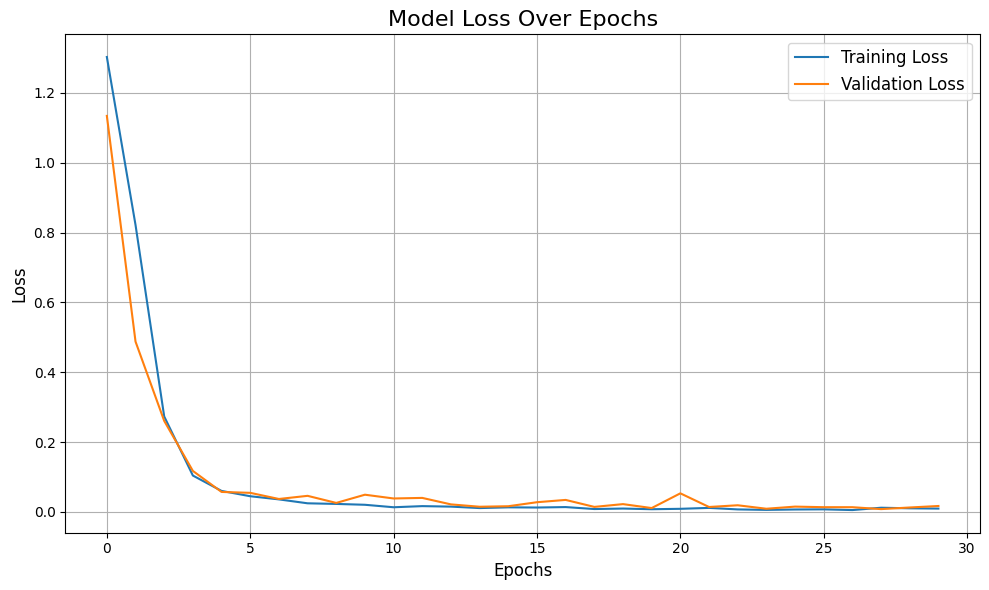

Loss plot saved to plots/loss_plot.svg

Generating and saving accuracy plot...


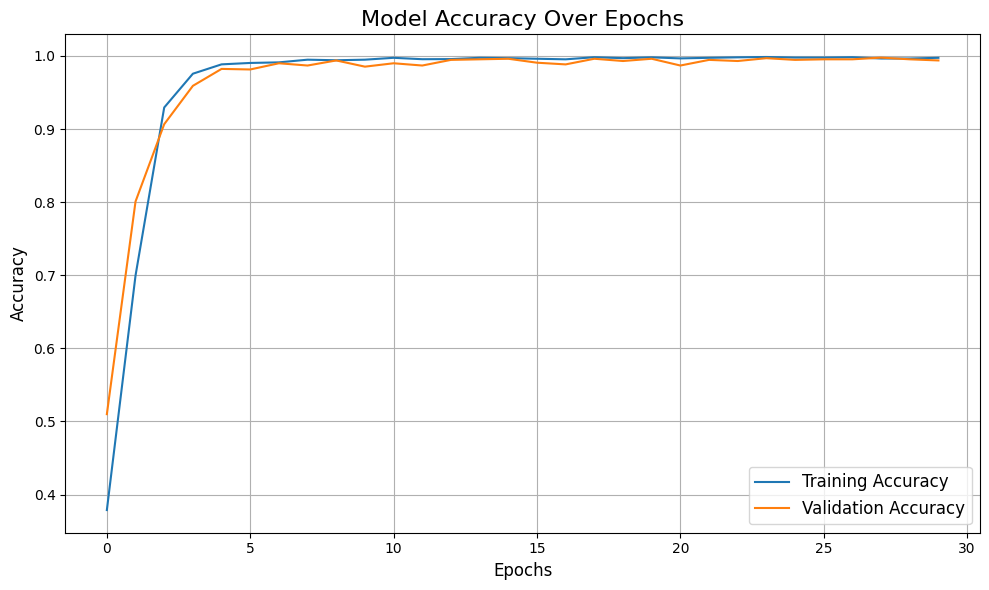

Accuracy plot saved to plots/accuracy_plot.svg

Generating and saving confusion matrix...


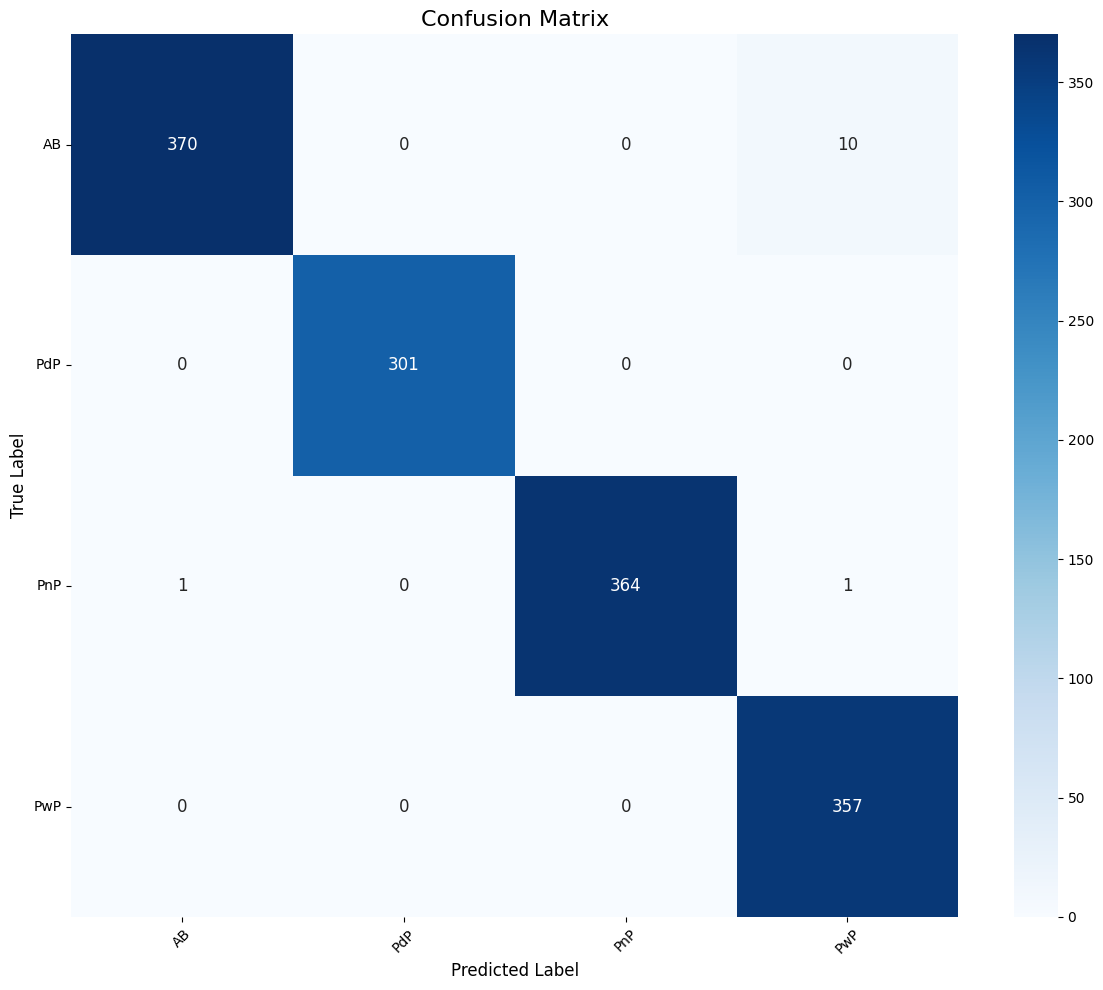

Confusion matrix saved to plots/confusion_matrix.svg


In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import os

# This script assumes 'history', 'model', 'test_loader', 'device', and
# 'nb_classes' are available from the preceding training script.

# Define a directory to save the plots
output_dir = "plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ==============================================================================
# 1. Plot Loss and Save as SVG
# ==============================================================================
print("Generating and saving loss plot...")
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
loss_filename = os.path.join(output_dir, "loss_plot.svg")
plt.savefig(loss_filename, format='svg')
plt.show()
print(f"Loss plot saved to {loss_filename}")


# ==============================================================================
# 2. Plot Accuracy and Save as SVG
# ==============================================================================
print("\nGenerating and saving accuracy plot...")
plt.figure(figsize=(10, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
accuracy_filename = os.path.join(output_dir, "accuracy_plot.svg")
plt.savefig(accuracy_filename, format='svg')
plt.show()
print(f"Accuracy plot saved to {accuracy_filename}")


# ==============================================================================
# 3. Plot Confusion Matrix and Save as SVG
# ==============================================================================
print("\nGenerating and saving confusion matrix...")

@torch.no_grad()
def get_all_preds(model, loader, device):
    """Function to get all predictions and labels from a dataloader."""
    model.eval()
    all_preds = torch.tensor([], dtype=torch.long).to(device)
    all_labels = torch.tensor([], dtype=torch.long).to(device)

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)

    return all_preds.cpu().numpy(), all_labels.cpu().numpy()

# Get predictions and true labels
y_pred, y_true = get_all_preds(model, test_loader, device)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class names for plotting
class_names = ['AB', 'PdP', 'PnP', 'PwP']

# Create a new figure for the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 12})

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
cm_filename = os.path.join(output_dir, "confusion_matrix.svg")
plt.savefig(cm_filename, format='svg')
plt.show()
print(f"Confusion matrix saved to {cm_filename}")

